In [1]:
# imports

import os
import os.path
import cv2
import glob
import h5py
import tqdm
import argparse
import logging
from PIL import Image 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_theme()
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

import data, utils, models

In [2]:
# FastDVDnet model definition take from their official github repository
# https://github.com/m-tassano/fastdvdnet

"""
Definition of the FastDVDnet model
Copyright (C) 2019, Matias Tassano <matias.tassano@parisdescartes.fr>
This program is free software: you can use, modify and/or
redistribute it under the terms of the GNU General Public
License as published by the Free Software Foundation, either
version 3 of the License, or (at your option) any later
version. You should have received a copy of this license along
this program. If not, see <http://www.gnu.org/licenses/>.
"""
import torch
import torch.nn as nn
import torch.nn.functional as F

class CvBlock(nn.Module):
    '''(Conv2d => BN => ReLU) x 2'''
    def __init__(self, in_ch, out_ch, mf2f=False):
        super(CvBlock, self).__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=mf2f),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=mf2f),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.convblock(x)

class InputCvBlock(nn.Module):
    '''(Conv with num_in_frames groups => BN => ReLU) + (Conv => BN => ReLU)'''
    def __init__(self, num_in_frames, out_ch, mf2f=False):
        super(InputCvBlock, self).__init__()
        self.interm_ch = 30
        self.convblock = nn.Sequential(
            nn.Conv2d(num_in_frames*(3+1), num_in_frames*self.interm_ch, \
                      kernel_size=3, padding=1, groups=num_in_frames, bias=mf2f),
            nn.BatchNorm2d(num_in_frames*self.interm_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(num_in_frames*self.interm_ch, out_ch, kernel_size=3, padding=1, bias=mf2f),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.convblock(x)

class DownBlock(nn.Module):
    '''Downscale + (Conv2d => BN => ReLU)*2'''
    def __init__(self, in_ch, out_ch, mf2f=False):
        super(DownBlock, self).__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, stride=2, bias=mf2f),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            CvBlock(out_ch, out_ch, mf2f=mf2f)
        )

    def forward(self, x):
        return self.convblock(x)

class UpBlock(nn.Module):
    '''(Conv2d => BN => ReLU)*2 + Upscale'''
    def __init__(self, in_ch, out_ch, mf2f=False):
        super(UpBlock, self).__init__()
        self.convblock = nn.Sequential(
            CvBlock(in_ch, in_ch, mf2f=mf2f),
            nn.Conv2d(in_ch, out_ch*4, kernel_size=3, padding=1, bias=mf2f),
            nn.PixelShuffle(2)
        )

    def forward(self, x):
        return self.convblock(x)

class OutputCvBlock(nn.Module):
    '''Conv2d => BN => ReLU => Conv2d'''
    def __init__(self, in_ch, out_ch, mf2f=False):
        super(OutputCvBlock, self).__init__()
        self.convblock = nn.Sequential(
            nn.Conv2d(in_ch, in_ch, kernel_size=3, padding=1, bias=mf2f),
            nn.BatchNorm2d(in_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=mf2f)
        )

    def forward(self, x):
        return self.convblock(x)

class DenBlock(nn.Module):
    """ Definition of the denosing block of FastDVDnet.
    Inputs of constructor:
        num_input_frames: int. number of input frames
    Inputs of forward():
        xn: input frames of dim [N, C, H, W], (C=3 RGB)
        noise_map: array with noise map of dim [N, 1, H, W]
    """

    def __init__(self, num_input_frames=3, mf2f=False):
        super(DenBlock, self).__init__()
        self.chs_lyr0 = 32
        self.chs_lyr1 = 64
        self.chs_lyr2 = 128

        self.inc = InputCvBlock(num_in_frames=num_input_frames, out_ch=self.chs_lyr0, mf2f=mf2f)
        self.downc0 = DownBlock(in_ch=self.chs_lyr0, out_ch=self.chs_lyr1, mf2f=mf2f)
        self.downc1 = DownBlock(in_ch=self.chs_lyr1, out_ch=self.chs_lyr2, mf2f=mf2f)
        self.upc2 = UpBlock(in_ch=self.chs_lyr2, out_ch=self.chs_lyr1, mf2f=mf2f)
        self.upc1 = UpBlock(in_ch=self.chs_lyr1, out_ch=self.chs_lyr0, mf2f=mf2f)
        self.outc = OutputCvBlock(in_ch=self.chs_lyr0, out_ch=3, mf2f=mf2f)

        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    def reset_params(self):
        for _, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, in0, in1, in2, noise_map):
        '''Args:
            inX: Tensor, [N, C, H, W] in the [0., 1.] range
            noise_map: Tensor [N, 1, H, W] in the [0., 1.] range
        '''
        # Input convolution block
        x0 = self.inc(torch.cat((in0, noise_map, in1, noise_map, in2, noise_map), dim=1))
        # Downsampling
        x1 = self.downc0(x0)
        x2 = self.downc1(x1)
        # Upsampling
        x2 = self.upc2(x2)
        x1 = self.upc1(x1+x2)
        # Estimation
        x = self.outc(x0+x1)

        # Residual
        x = in1 - x

        return x

class FastDVDnet(nn.Module):
    """ Definition of the FastDVDnet model.
    Inputs of forward():
        xn: input frames of dim [N, C, H, W], (C=3 RGB)
        noise_map: array with noise map of dim [N, 1, H, W]
    """

    def __init__(self, num_input_frames=5, mf2f=False):
        super(FastDVDnet, self).__init__()
        self.num_input_frames = num_input_frames
        # Define models of each denoising stage
        self.temp1 = DenBlock(num_input_frames=3, mf2f=mf2f)
        self.temp2 = DenBlock(num_input_frames=3, mf2f=mf2f)
        # Init weights
        self.reset_params()

    @staticmethod
    def weight_init(m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')

    def reset_params(self):
        for _, m in enumerate(self.modules()):
            self.weight_init(m)

    def forward(self, x, noise_map):
        '''Args:
            x: Tensor, [N, num_frames*C, H, W] in the [0., 1.] range
            noise_map: Tensor [N, 1, H, W] in the [0., 1.] range
        '''
        # hack
        N, C, H, W = x.shape
        if(H%4 != 0):
            x = F.pad(x, [0, 0, 4-(H%4), 0], mode = 'reflect')
            noise_map = F.pad(noise_map, [0, 0, 4-(H%4), 0], mode = 'reflect')
        if(W%4 != 0):
            x = F.pad(x, [4-(W%4), 0, 0, 0], mode = 'reflect')
            noise_map = F.pad(noise_map, [4-(W%4), 0, 0, 0], mode = 'reflect')
        
        # Unpack inputs
        (x0, x1, x2, x3, x4) = tuple(x[:, 3*m:3*m+3, :, :] for m in range(self.num_input_frames))

        # First stage
        self.f1 = x20 = self.temp1(x0, x1, x2, noise_map)
        self.f2 = x21 = self.temp1(x1, x2, x3, noise_map)
        self.f3 = x22 = self.temp1(x2, x3, x4, noise_map)

        #Second stage
        x = self.temp2(x20, x21, x22, noise_map)
        
        # unhack
        N1, C1, H1, W1 = x.shape
        if(H%4 != 0):
            x = x[:, :, (4-(H%4)):H1, 0:W1]
        if(W%4 != 0):
            x = x[:, :, 0:H, (4-(W%4)):W1]

        return x

In [3]:
# definition for loading model from a pretrained network file

def load_model(PATH, Fast=False, parallel=False, pretrained=True, old=True, load_opt=False, mf2f=False):
    if not Fast:
        state_dict = torch.load(PATH, map_location="cpu")
        args = argparse.Namespace(**{**vars(state_dict["args"])})
        # ignore this
        if old:
            vars(args)['blind_noise'] = False

        model = models.build_model(args)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    else:
        model = FastDVDnet(mf2f=mf2f)
    
    if load_opt:
        for o, state in zip([optimizer], state_dict["optimizer"]):
            o.load_state_dict(state)
    
    if pretrained:
        if Fast:
            state_dict = torch.load(PATH)
        else:
            state_dict = torch.load(PATH)["model"][0]
        own_state = model.state_dict()
        
        for name, param in state_dict.items():
            if parallel:
                name = name[7:]
            if Fast and not mf2f:
                name = name.split('.', 1)[1]
            if name not in own_state:
                print("here", name)
                continue
            if isinstance(param, nn.Parameter):
                # backwards compatibility for serialized parameters
                param = param.data
            own_state[name].copy_(param)
        
    if not Fast:
        return model, optimizer, args
    else:
        return model

In [4]:
# necessary variable definitions

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
transform = transforms.Compose([transforms.ToPILImage()])
to_gray = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1)])

dataset = "GoPro"
video = "rafting"
patch_size = 128
stride = 64
is_image = False
n_frames = 5
cpf = 3
mid = n_frames // 2
is_real = False

aug = 0

dist = 'G'
mode = 'S'
# change noise_std parameter here to produce results at various noise levels
noise_std = 30
min_noise = 0
max_noise = 100

batch_size = 1
lr = 1e-4

In [5]:
# data loader

PATH = os.path.join("datasets/Set8", dataset)

train_loader, test_loader = data.build_dataset("SingleVideo", PATH, batch_size=batch_size, dataset=dataset, video=video, image_size=patch_size, stride=stride, n_frames=n_frames, 
                                               aug=aug, dist=dist, mode=mode, noise_std=noise_std, min_noise=min_noise, max_noise=max_noise,
                                               sample=True)

In [6]:
# frame to denoise

C, H, W = test_loader.dataset[0][0].shape

num = 15
x = 0; y = 0; w = W; h = H

images = []
psnrs = []
ssims = []

sample, noisy_inputs = test_loader.dataset[num]
sample = sample[:, y:y+h, x:x+w].unsqueeze(0).to(device)
noisy_inputs = noisy_inputs[:, y:y+h, x:x+w].unsqueeze(0).to(device)
 
# For sampling independent new nooise
# noisy_inputs = sample + utils.get_noise(sample, noise_std=noise_std)

N, C, H, W = sample.shape
clean_image = sample[:, 6:9, :, :]
noisy_frame = noisy_inputs[:, 6:9, :, :]

images.append(np.array(transform(clean_image[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, clean_image, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, clean_image, normalized=True, raw=False))

images.append(np.array(transform(noisy_frame[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, noisy_frame, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, noisy_frame, normalized=True, raw=False))

/ext3/anaconda3/lib/python3.8/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


In [7]:
# FastDVDnet

PATH = "pretrained/fast_dvd_net.pth"
model = load_model(PATH, Fast=True).to(device).eval()

noise_map = (noise_std/255)*torch.ones(N, 1, H, W).to(device)

with torch.no_grad():
    output = model(noisy_inputs, noise_map)

images.append(np.array(transform(output[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, output, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, output, normalized=True, raw=False))

In [8]:
# MF2F

PATH = "pretrained/mf2f_online_with_teacher_rafting_30.pth"
model = load_model(PATH, Fast=True, mf2f=True).to(device).eval()

noise_map = (noise_std/255)*torch.ones(N, 1, H, W).to(device)

with torch.no_grad():
    output = model(noisy_inputs, noise_map)

images.append(np.array(transform(output[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, output, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, output, normalized=True, raw=False))

In [9]:
# UDVD (1 Frame)

PATH = "pretrained/blind_spot_net.pt"
model, _, _ = load_model(PATH, parallel=True)
model.to(device).eval()

with torch.no_grad():
    output, _ = model(noisy_frame)
    output, mean_image = utils.post_process(output, noisy_frame, model = "blind-video-net", sigma = noise_std/255, device=device)

images.append(np.array(transform(output[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, output, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, output, normalized=True, raw=False))

In [10]:
# UDVD

PATH = "pretrained/blind_video_net.pt"
model, _, _ = load_model(PATH, parallel=True)
model.to(device).eval()

with torch.no_grad():
    output, _ = model(noisy_inputs)
    output, mean_image = utils.post_process(output, noisy_frame, model = "blind-video-net", sigma = noise_std/255, device=device)

images.append(np.array(transform(output[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, output, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, output, normalized=True, raw=False))

In [11]:
# UDVD-S (single video)

PATH = "pretrained/single_video_Set8_rafting_30.pt"

model, _, _ = load_model(PATH, parallel=True, old=False)
model.to(device).eval()

with torch.no_grad():
    output, _ = model(noisy_inputs)
    output, mean_image = utils.post_process(output, noisy_frame, model = "blind-video-net", sigma = noise_std/255, device=device)

images.append(np.array(transform(output[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, output, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, output, normalized=True, raw=False))

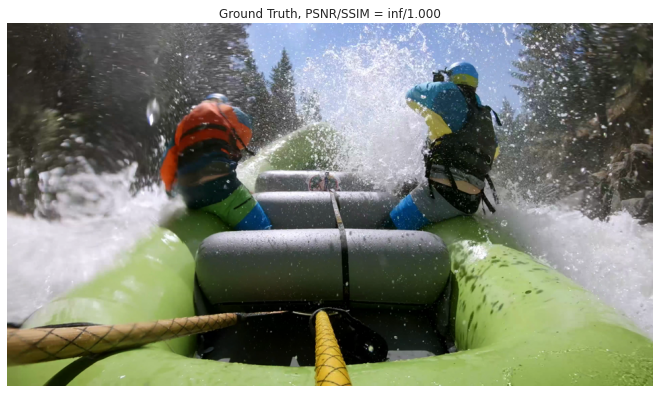

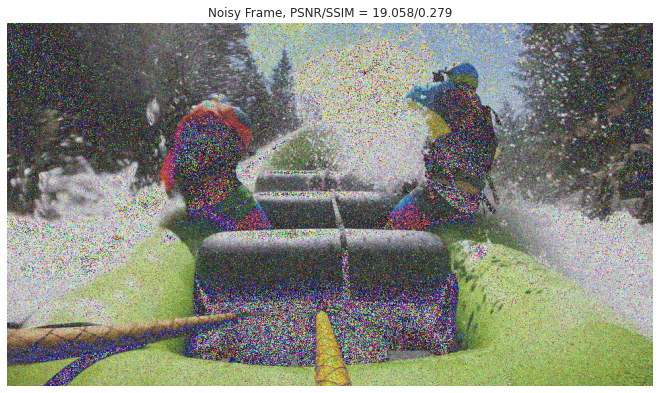

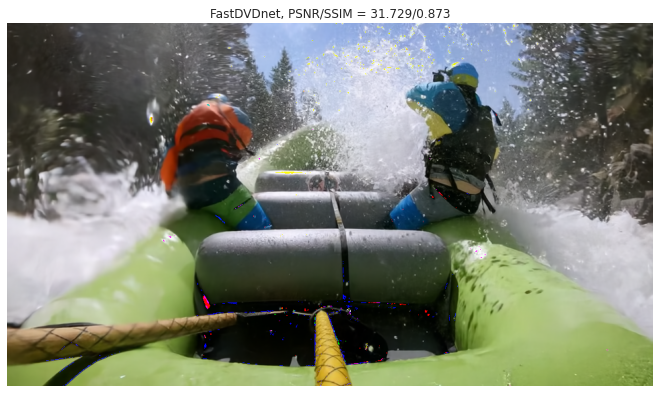

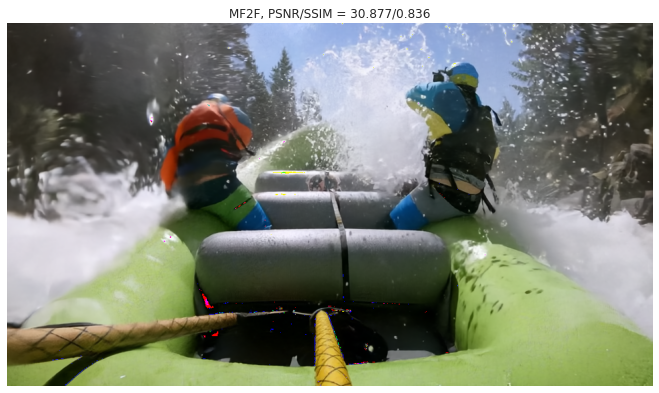

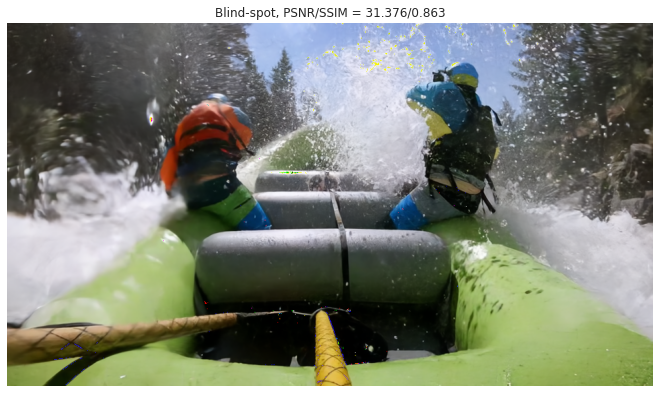

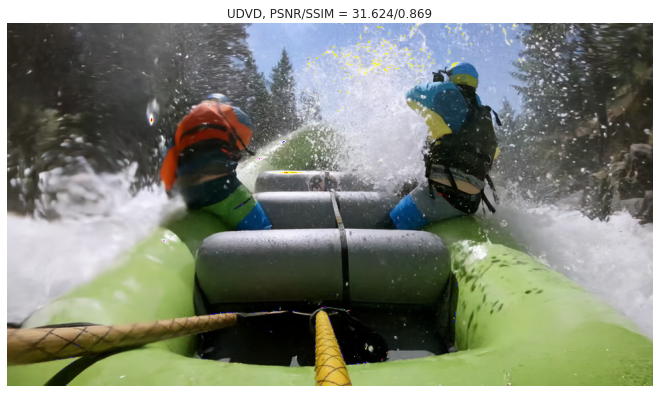

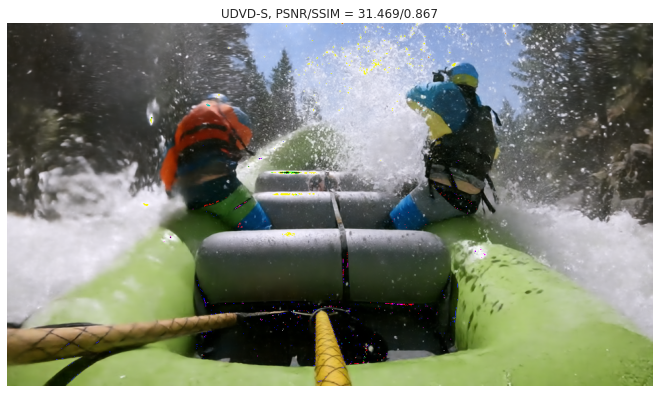

In [12]:
# plotting all images for comparison

names = ["Ground Truth", "Noisy Frame", "FastDVDnet", "MF2F", "Blind-spot", "UDVD", "UDVD-S"]

for i in range(len(names)):
    fig, ax = plt.subplots(figsize=(10, (9/16)*10))
    
    ax.imshow(images[i])
    ax.set_title("%s, PSNR/SSIM = %.3f/%.3f" % (names[i], psnrs[i], ssims[i]))
    ax.axis("off")
    
    plt.tight_layout()

In [13]:
# UDVD - example video gif
# Change model definition according to the code above for denoised videos of different models

PATH = "pretrained/blind_video_net.pt"
model, _, _ = load_model(PATH, parallel=True)
model.to(device).eval()

frames = []
os.makedirs(os.path.join("examples", video), exist_ok=True)
save_dir = os.path.join("examples", video)
C, H, W = test_loader.dataset[0][0].shape
w = W; h = H; x = 0; y = 0

with torch.no_grad():
    for i, (sample, noisy_inputs) in enumerate(test_loader):
        sample = sample[:,:,y:y+h,x:x+w].to(device)
        noisy_inputs = noisy_inputs[:,:,y:y+h,x:x+w].to(device)
        
        N, C, H, W = sample.shape
        clean_image = sample[:, 6:9, :, :]
        noisy_frame = noisy_inputs[:, 6:9, :, :]
        
        output, _ = model(noisy_inputs)
        output, mean_image = utils.post_process(output, noisy_frame, model = "blind-video-net", sigma = noise_std/255, device=device)
        
        img = np.array(transform(output[0].cpu().detach()))
        noisy_img = np.array(transform(noisy_frame[0].cpu().detach()))
        
        frame = cv2.cvtColor(np.append(noisy_img, img, axis=0), cv2.COLOR_RGB2BGR)
        
        cv2.line(frame, (0,H), (W,H), (0,0,255), 1)
        
        cv2.imwrite(os.path.join(save_dir, "%05d.jpg" % (i)), frame)
        
        frames.append(frame)

In [14]:
# combining frames into mp4 video

fps = 30
video_path = os.path.join(save_dir, f"{video}.mp4")
height, width, layers = frames[0].shape
out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
for i in range(len(frames)):
    out.write(frames[i])
out.release()
cv2.destroyAllWindows()

In [15]:
# converting mp4 to a gif video (optional)

from moviepy.editor import *

video_path = os.path.join(save_dir, f"{video}.mp4")
gif_path = os.path.join(save_dir, f"{video}.gif")

clip = (VideoFileClip(video_path).resize(0.5))
clip.write_gif(gif_path)

t:   7%|▋         | 2/30 [00:00<00:02, 11.46it/s, now=None]

MoviePy - Building file examples/rafting/rafting.gif with imageio.
